Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


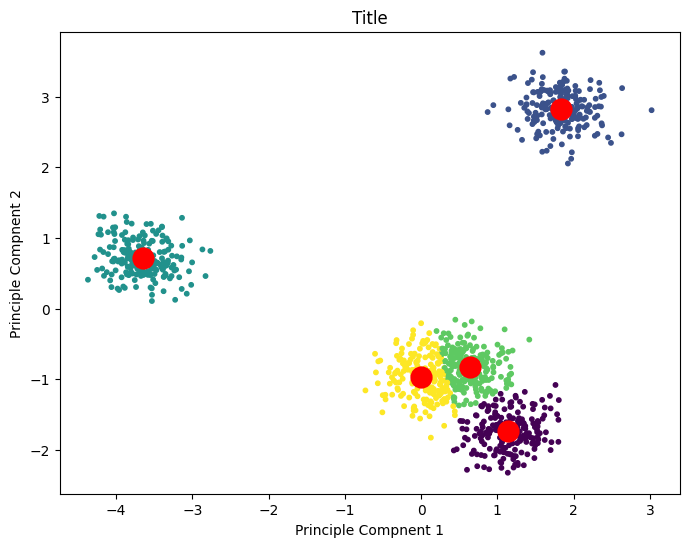

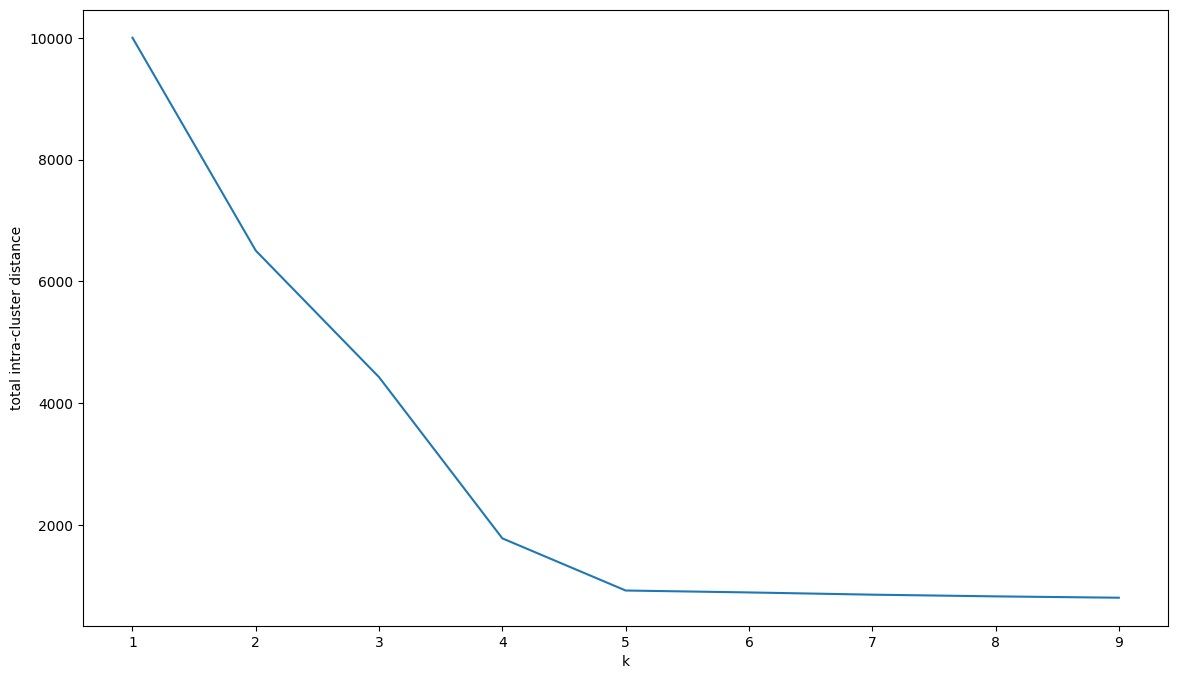

In [25]:
# your code here
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#PCA Clustering
X_PCA = PCA(n_components=2).fit_transform(X)

#kMean Model
kmeans_model = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans_model.fit(X_PCA)

#Lables and Centers
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

#Plot PCA points colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=169, linewidths=3, color='red', zorder=10)
plt.title("Title")
plt.xlabel("Principle Compnent 1")
plt.ylabel("Principle Compnent 2")
plt.show()

#Elbow Analysis
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

#Plot Elbow Curve
fig = plt.figure(figsize=(14, 8))
plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


In [ ]:
# your code here

# 3. Dimensionality reduction for Fashion-MNIST

In [ ]:
# your code here

# 4. Clustering Fashion-MNIST using spectral clustering

In [ ]:
# your code here